# Playground ML Parameterizations

## Linear Regression

In [1]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np

%matplotlib inline

In [2]:
np.random.seed(42)

#### Data generation

In [4]:
w = torch.as_tensor([3.0, 2])
w
# where 3 is the intersection point (sometimes also called bias) and 
# 2 is the slope.

tensor([3., 2.])

In [8]:
# We create 100 data points.
n = 100
x = torch.ones(n, 2)

# uniformly sample x points between -1 and 1.
# Underscore functions in pytorch means replace the value (update)
x[:, 1].uniform_(-1.0, 1)

x[:6]

tensor([[ 1.0000,  0.1800],
        [ 1.0000,  0.1734],
        [ 1.0000,  0.3926],
        [ 1.0000, -0.2876],
        [ 1.0000,  0.6152],
        [ 1.0000,  0.9393]])

In [9]:
# Generate output data.
y = x @ w + torch.rand(n)  # @ is a matrix product (similar to matmul)

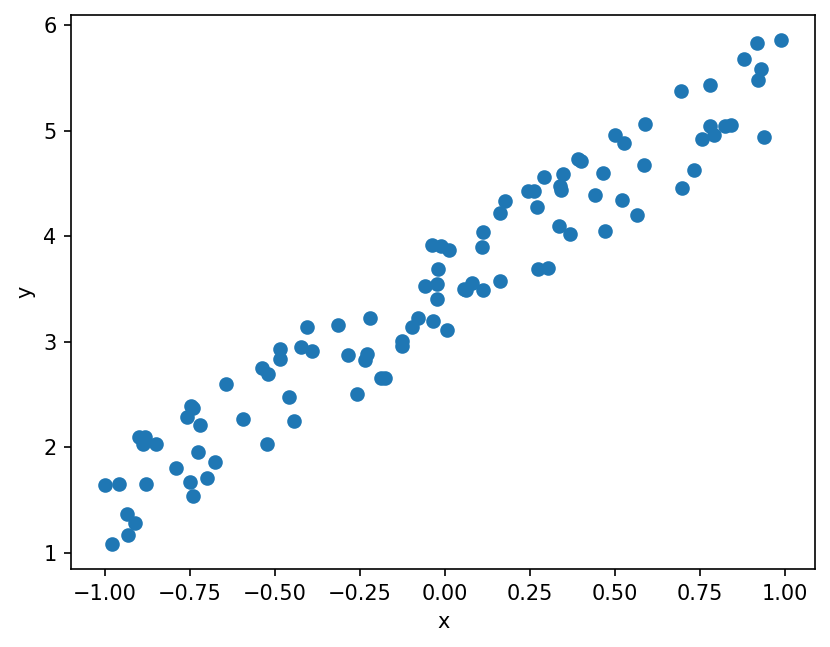

In [7]:
plt.figure(dpi=150)
plt.scatter(x[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.show();

#### Loss function

In [10]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [11]:
# Initialize parameters with some randomly guessed values.
w_real = torch.as_tensor([-3.0, -5])
y_hat = x @ w_real
# Initial mean-squared error
mse(y_hat, y)

tensor(54.0640)

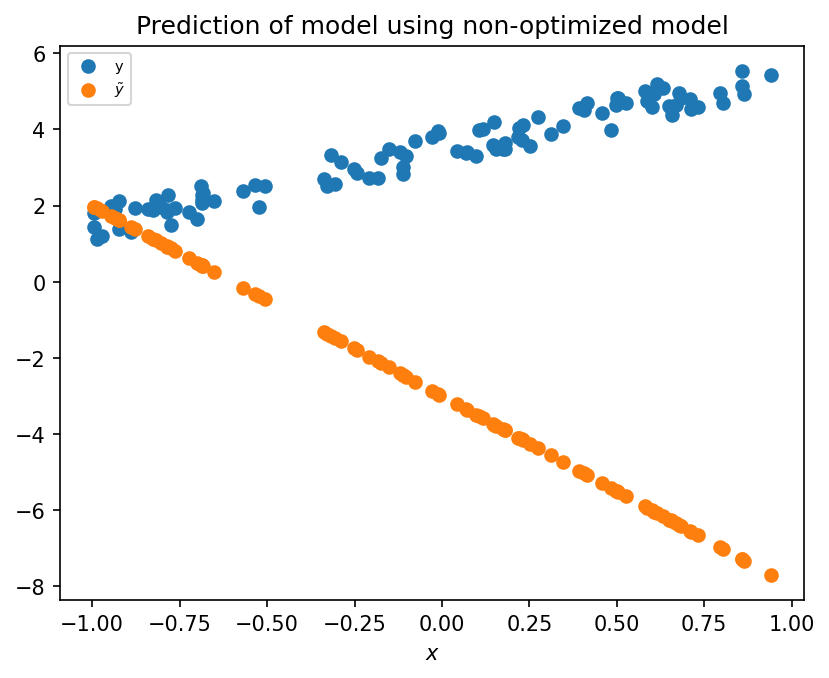

In [12]:
plt.figure(dpi=150)
plt.scatter(x[:, 1], y, label="y")
plt.scatter(x[:, 1], y_hat, label="$\\tilde{y}$")
plt.xlabel("$x$")
plt.title("Prediction of model using non-optimized model")
plt.legend(fontsize=7);

In [13]:
# Initialize parameter obect that will be optimized.
w = nn.Parameter(w_real)
w

Parameter containing:
tensor([-3., -5.], requires_grad=True)

#### Gradient descent and optimization

In [14]:
def step(lr):
    y_hat = x @ w
    loss = mse(y, y_hat)
    # calculate the gradient of a tensor! It is now stored at w.grad
    loss.backward()

    # To prevent tracking history and using memory
    # (code block where we don't need to track the gradients but only modify the values of tensors)
    with torch.no_grad():
        # lr is the learning rate. Good learning rate is a key part of Neural Networks.
        w.sub_(lr * w.grad)
        # We want to zero the gradient before we are re-evaluate it.
        w.grad.zero_()

    return loss.detach().item(), y_hat.detach().numpy()

In [15]:
w = torch.as_tensor([-2.0, -3])
w = nn.Parameter(w)
lr = 0.1
losses = [float("inf")]
y_hats = []
epoch = 100

In [16]:
# Train model and perform gradient descent
for _ in range(epoch):
    loss, y_hat = step(lr)
    losses.append(loss)
    y_hats.append(y_hat)

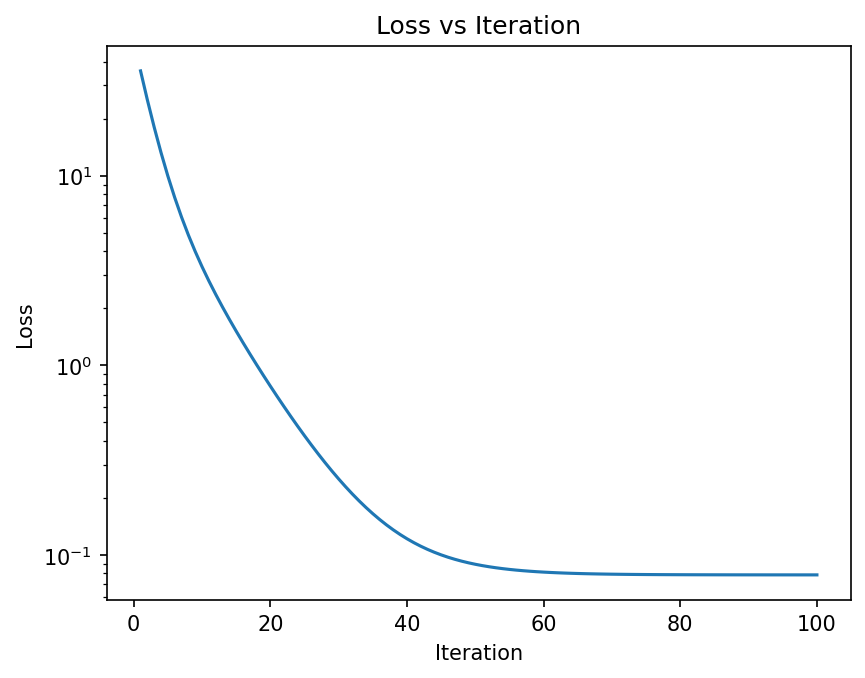

In [17]:
plt.figure(dpi=150)
plt.plot(np.array(losses))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=80)
axs[0].scatter(x[:, 1], y, label="y")
scatter_yhat = axs[0].scatter(x[:, 1], y_hat, label="$\\tilde{y}$")
axs[0].set_xlabel("$x$")
axs[0].legend(fontsize=7)

(line,) = axs[1].plot(range(len(losses)), np.array(losses))
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss vs Iteration")
plt.close()


def animate(i):
    axs[0].set_title("Loss = %.2f" % losses[i])
    scatter_yhat.set_offsets(np.c_[[], []])
    scatter_yhat.set_offsets(np.c_[x[:, 1], y_hats[i]])
    line.set_data(np.array(range(i + 1)), np.array(losses[: (i + 1)]))
    return scatter_yhat, line


plt.show()

animation = FuncAnimation(fig, animate, frames=epoch, interval=100, blit=True)
# let animation load
time.sleep(1)
plt.show()

## Neural Networks

In [22]:
# We create many data points, as neural networks need lot of data to train from scratch.
n = 10000
x = torch.ones(n, 1)

# uniformly sample x points between -1 and 1.
# Underscore functions in pytorch means replace the value (update)
x = x.uniform_(-1.0, 1)

y = torch.sin(x * 2 * torch.pi) + 0.1 * torch.rand(n, 1)

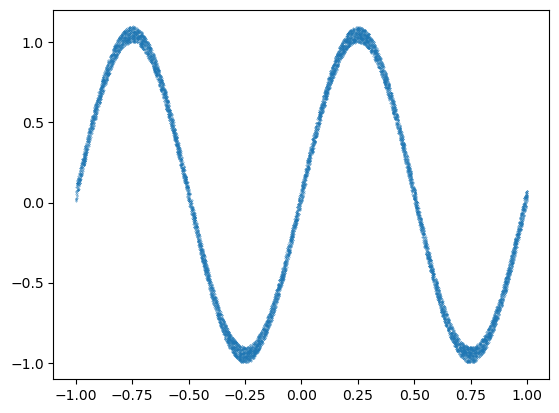

In [23]:
plt.plot(x[:, 0], y, ".", markersize=0.5)

In [24]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(1, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x

In [25]:
neural_net = Simple_Neural_Net()

In [26]:
net_input = torch.randn(1, 1)
out = neural_net(net_input)
print(
    f"The output of the random input {net_input.item():.4f} from untrained network is: {out.item():.4f}"
)

The output of the random input -0.1631 from untrained network is: -0.0562


In [27]:
# Here we use the Adam optimizer.
learning_rate = 0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [29]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [30]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [31]:
epochs = 1000
Loss = np.zeros(epochs)
for t in range(epochs):
    Loss[t] = train_step(neural_net, loss_fn, optimizer)
    if np.mod(t, 200) == 0:
        print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  0.507145881652832
Loss at Epoch 201 is  0.19514113664627075
Loss at Epoch 401 is  0.031256623566150665
Loss at Epoch 601 is  0.010938096791505814
Loss at Epoch 801 is  0.004333969205617905


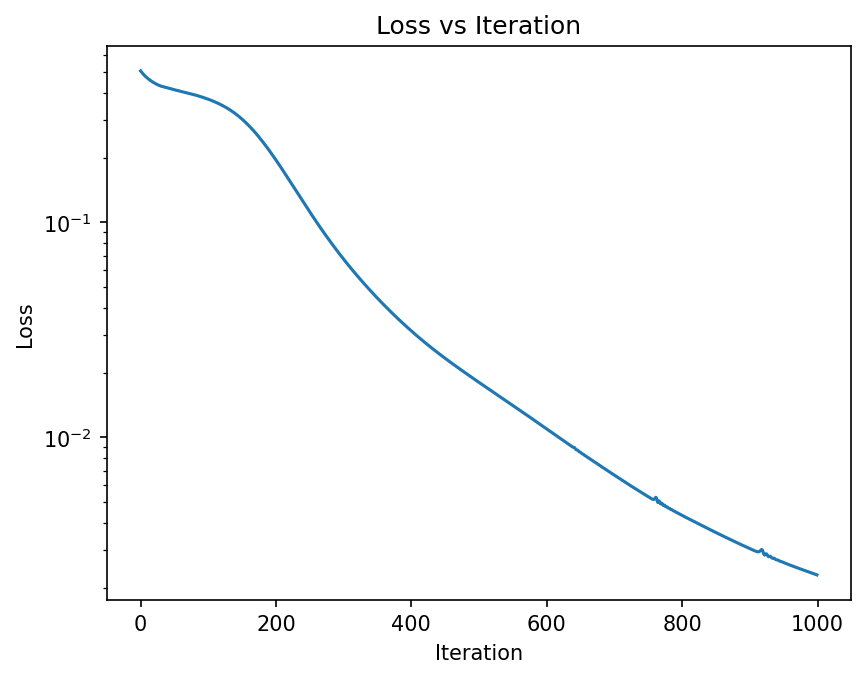

In [32]:
plt.figure(dpi=150)
plt.plot(Loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

In [33]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.
x_test = torch.linspace(-1.5, 1.5, 501).reshape(501, 1)

# Generate the predictions from the trained model.
pred = neural_net(x_test).detach().numpy()

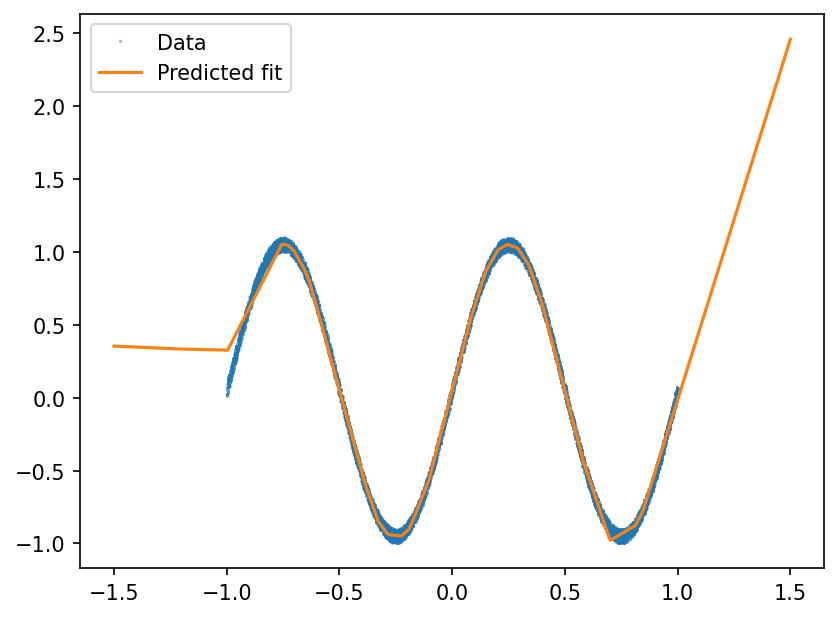

In [34]:
plt.figure(dpi=150)

plt.plot(x, y, ".", markersize=0.5, label="Data")
plt.plot(x_test, pred, markersize=0.5, label="Predicted fit")

plt.legend()

## NNs for L96 Parameterizations: Offline Training

### Generating the data

In [37]:
import sys
# Add src folder to path for importing modules
sys.path.insert(1, "../src")

In [38]:
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

from lorenz96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [39]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

#### Real world ground truth

In [89]:
time_steps = 20000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=forcing)

In [90]:
# The effect of Y on X is `xy_true`
X_true, _, _, xy_true = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true, xy_true = X_true.astype(np.float32), xy_true.astype(np.float32)

In [91]:
# Number of time steps for validation
val_size = 4000

# Training Data
X_true_train = X_true[
    :-val_size, :
]  # Flatten because we first use single input as a sample
subgrid_tend_train = xy_true[:-val_size, :]

# Test Data
X_true_test = X_true[-val_size:, :]
subgrid_tend_test = xy_true[-val_size:, :]

In [92]:
X_true_train.shape

(16001, 8)

#### Dataloaders

In [93]:
# Number of sample in each batch
BATCH_SIZE = 2000
# this batch size would result in 2 test batches and 8 training batches.

In [94]:
local_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_train, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)),
)

local_loader = Data.DataLoader(
    dataset=local_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [95]:
local_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(X_true_test, -1)),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)),
)

local_loader_test = Data.DataLoader(
    dataset=local_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

X (State):
 tensor([ 3.8691,  8.9025,  3.3220,  ..., -0.3817,  4.9343,  4.0652])

Y (Subgrid Tendency):
 tensor([-7.0107, -6.5600, -6.5453,  ...,  0.2964, -7.0780, -6.2009])


(-12.0, 16.0)

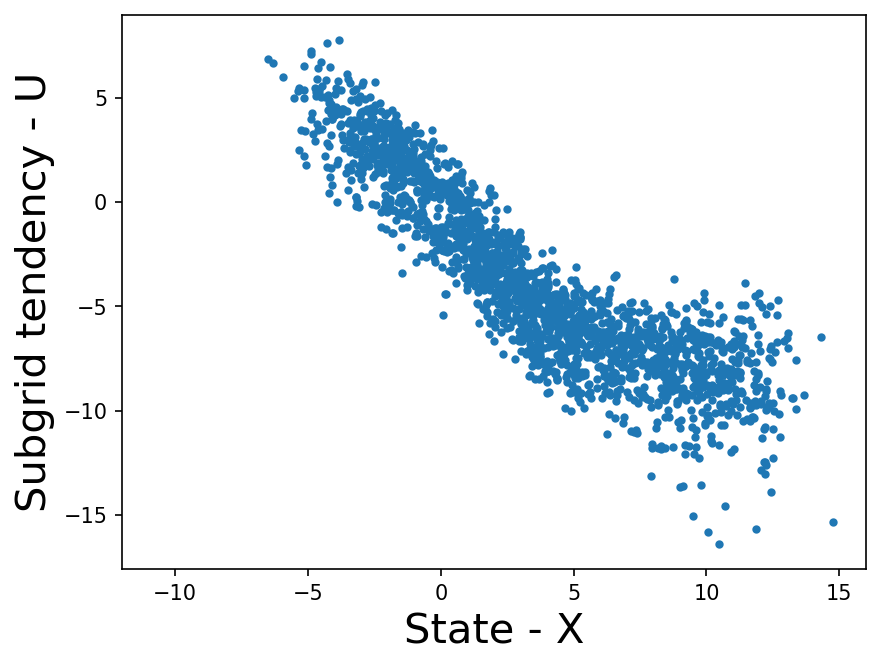

In [96]:
# Iterating over the data to get one batch
data_iterator = iter(local_loader)
X_iter, subgrid_tend_iter = next(data_iterator)

print("X (State):\n", X_iter)
print("\nY (Subgrid Tendency):\n", subgrid_tend_iter)

plt.figure(dpi=150)
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - U", fontsize=20)
plt.xlim([-12, 16])

### Local ML models

Predict $U_k$ at specific $k$ from same local $X_k$

#### Linear regression network

In [97]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

In [98]:
linear_network = LinearRegression()
linear_network

LinearRegression(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)

#### Fully connected NN

In [99]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 1)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [100]:
fcnn_network = FCNN()
fcnn_network

FCNN(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

#### Loss function

In [101]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [102]:
# Load the input and output pair from the data loader
X_tmp = next(iter(local_loader))

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1))
y_tmp_fcnn = fcnn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_fcnn = loss_fn(y_tmp_fcnn, torch.unsqueeze(X_tmp[1], 1))
print(f"FCNN MSE Loss: {loss_fcnn.item():.4f}")

Linear network MSE Loss: 12.4554
FCNN MSE Loss: 35.4066


#### Optimizer

In [103]:
learning_rate = 0.003
momentum = 0.1

In [104]:
# switch the commenting out below to try a different optimizer.
# optimizer_linear = optim.SGD(linear_network.parameters(), lr=learning_rate, momentum=momentum)
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate)
print("Before backward pass: \n", list(linear_network.parameters())[0].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

Before backward pass: 
 [[-0.58870375]]

After backward pass: 
 [[-0.5917038]]


In [105]:
# optimizer_fcnn = optim.SGD(fcnn_network.parameters(), lr=learning_rate, momentum=momentum)
optimizer_fcnn = optim.Adam(fcnn_network.parameters(), lr=learning_rate)

#### Train and test functions

In [106]:
def train_model(network, criterion, loader, optimizer):
    """Train the network for one epoch"""
    network.train()

    train_loss = 0
    for batch_x, batch_y in loader:
        # Get predictions
        if len(batch_x.shape) == 1:
            # This if block is needed to add a dummy dimension if our inputs are 1D
            # (where each number is a different sample)
            prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
        else:
            prediction = network(batch_x)

        # Compute the loss
        loss = criterion(prediction, batch_y)
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)

In [107]:
def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers)

    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            # Get predictions
            if len(batch_x.shape) == 1:
                # This if block is needed to add a dummy dimension if our inputs are 1D
                # (where each number is a different sample)
                prediction = torch.squeeze(network(torch.unsqueeze(batch_x, 1)))
            else:
                prediction = network(batch_x)

            # Compute the loss
            loss = criterion(prediction, batch_y)
            test_loss += loss.item()

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss

In [108]:
def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end_time = time.time()
    print(f"Training completed in {int(end_time - start_time)} seconds.")

    return train_losses, test_losses

#### Train the networks

In [109]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 15

In [110]:
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, local_loader, local_loader_test, n_epochs
)

Training completed in 7 seconds.


In [111]:
train_loss_fcnn, test_loss_fcnn = fit_model(
    fcnn_network, loss_fn, optimizer_fcnn, local_loader, local_loader_test, n_epochs
)

Training completed in 7 seconds.


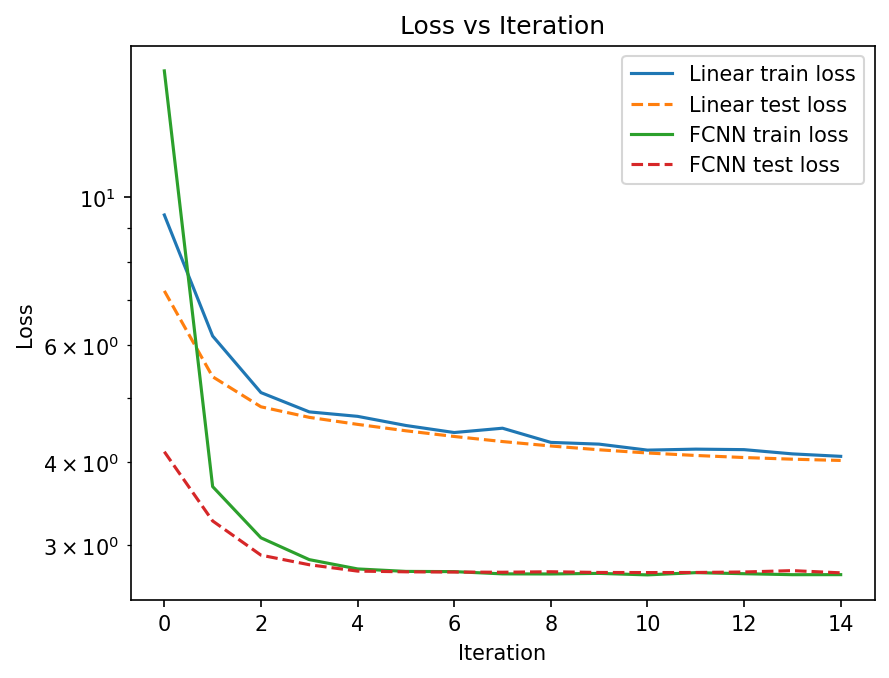

In [112]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_fcnn, label="FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="FCNN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

#### Compare with ground truth

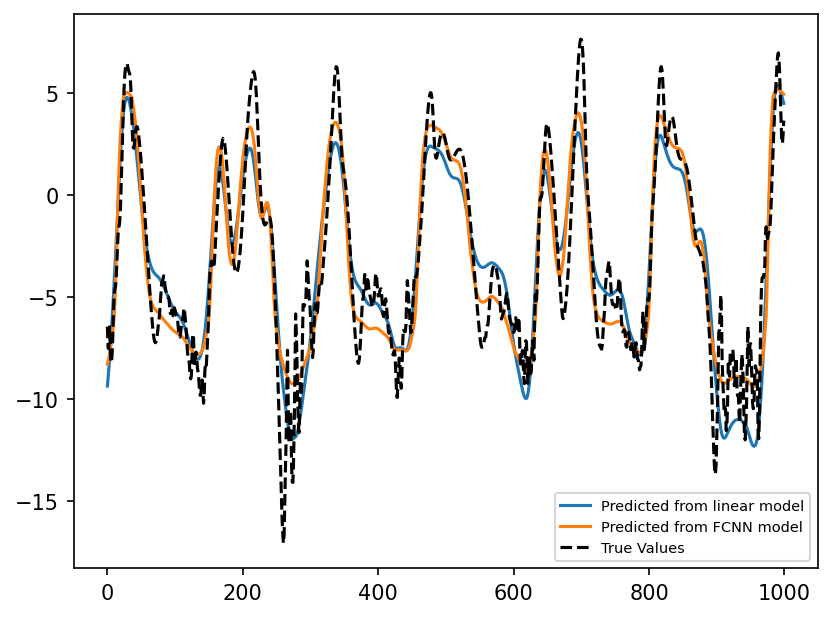

In [113]:
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)
predictions_fcnn = fcnn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, 1], -1)), 1)
)


plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Predicted from linear model"
)
plt.plot(predictions_fcnn.detach().numpy()[0:1000], label="Predicted from FCNN model")
plt.plot(subgrid_tend_test[:1000, 1], label="True Values", color="k", linestyle="--")
plt.legend(fontsize=7);

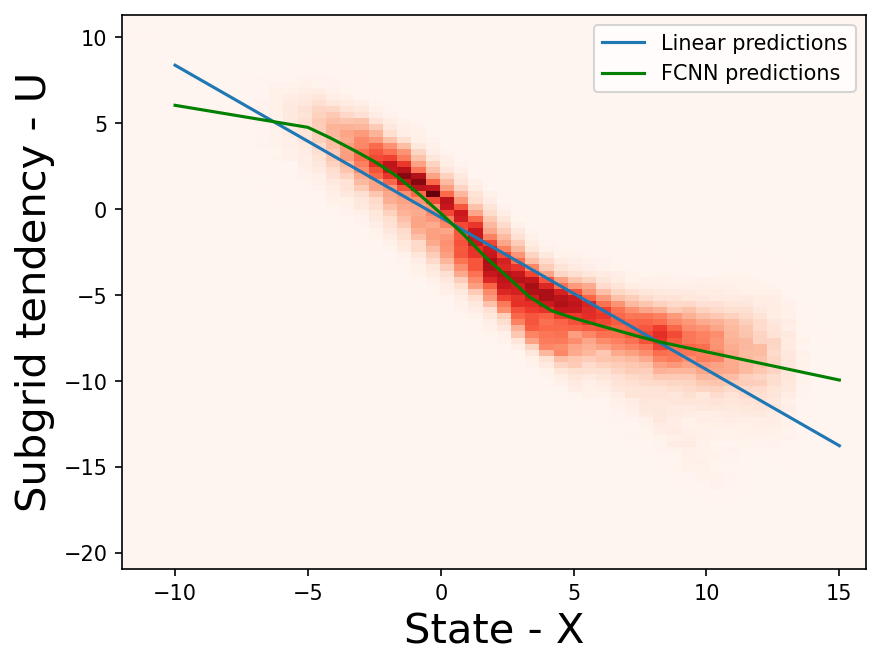

In [114]:
X_points = torch.from_numpy(np.linspace(-10, 15, 31).astype(np.float32))

linear_pred = linear_network(torch.unsqueeze(X_points, 1)).detach().numpy()

fcnn_pred = fcnn_network(torch.unsqueeze(X_points, 1)).detach().numpy()


plt.figure(dpi=150)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")

plt.plot(X_points, linear_pred, "-", label="Linear predictions")
plt.plot(X_points, fcnn_pred, "-", label="FCNN predictions", color="g")

plt.legend()
plt.xlim([-12, 16])
plt.xlabel("State - X", fontsize=20)
plt.ylabel("Subgrid tendency - U", fontsize=20);

### Non-local ML models

Predict $U_k$ from neighboring $X_k$ 

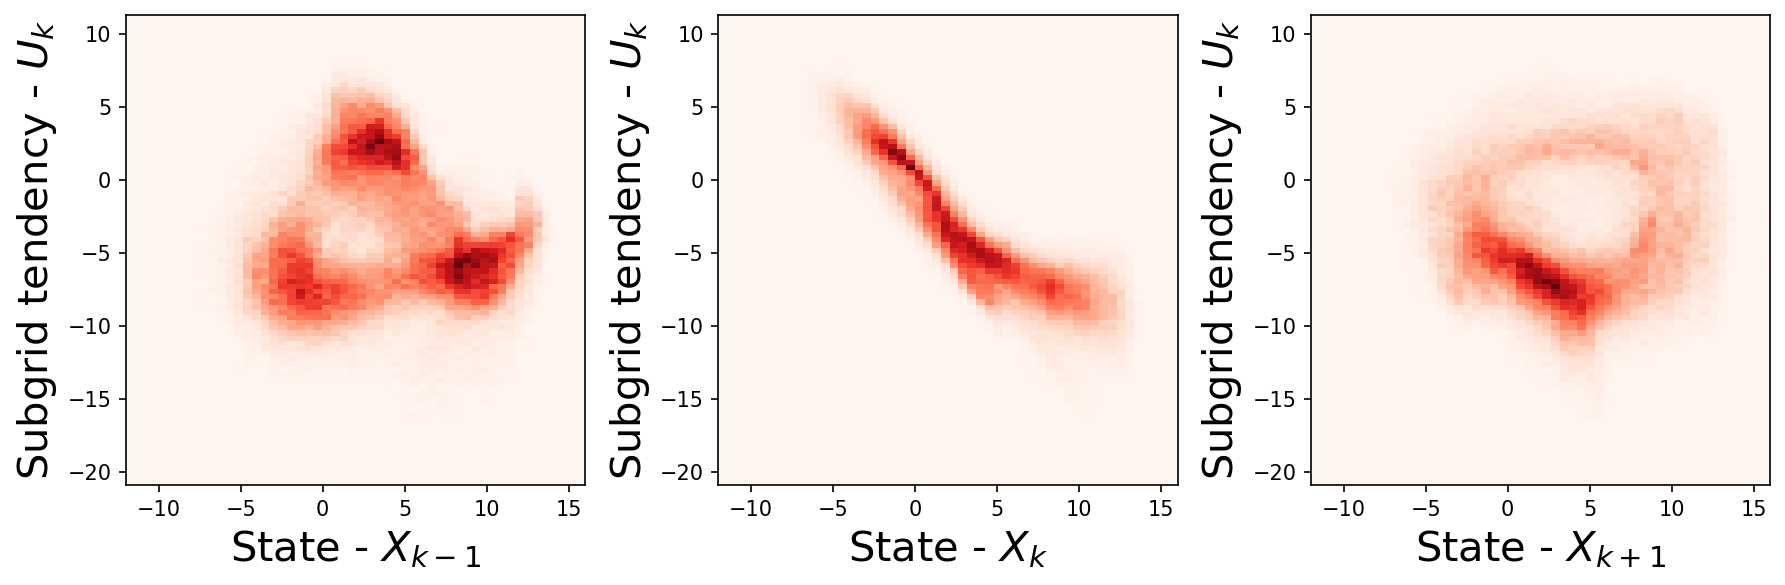

In [115]:
plt.figure(figsize=(12, 4), dpi=150)

plt.subplot(131)
plt.hist2d(
    np.reshape(np.roll(X_true, -1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k-1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.subplot(132)
plt.hist2d(np.reshape(X_true, -1), np.reshape(xy_true, -1), bins=91, cmap="Reds")
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.subplot(133)
plt.hist2d(
    np.reshape(np.roll(X_true, 1, axis=1), -1),
    np.reshape(xy_true, -1),
    bins=91,
    cmap="Reds",
)
plt.xlim([-12, 16])
plt.xlabel("State - $X_{k+1}$", fontsize=20)
plt.ylabel("Subgrid tendency - $U_{k}$", fontsize=20)

plt.tight_layout()

In [116]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train),
    torch.from_numpy(subgrid_tend_train),
)
nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=True
)


# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test), torch.from_numpy(subgrid_tend_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=True
)

In [117]:
class NonLocal_FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [118]:
nonlocal_fcnn_network = NonLocal_FCNN()

In [123]:
# optimizer_nonlocal_fcnn = optim.SGD(nonlocal_fcnn_network.parameters(),
#                                    lr=learning_rate, momentum=momentum)
optimizer_nonlocal_fcnn = optim.Adam(
    nonlocal_fcnn_network.parameters(), lr=learning_rate
)

In [124]:
n_epochs = 120
train_loss_nonlocal, test_loss_nonlocal = fit_model(
    nonlocal_fcnn_network,
    loss_fn,
    optimizer_nonlocal_fcnn,
    nlocal_loader_train,
    nlocal_loader_test,
    n_epochs,
)

Training completed in 7 seconds.


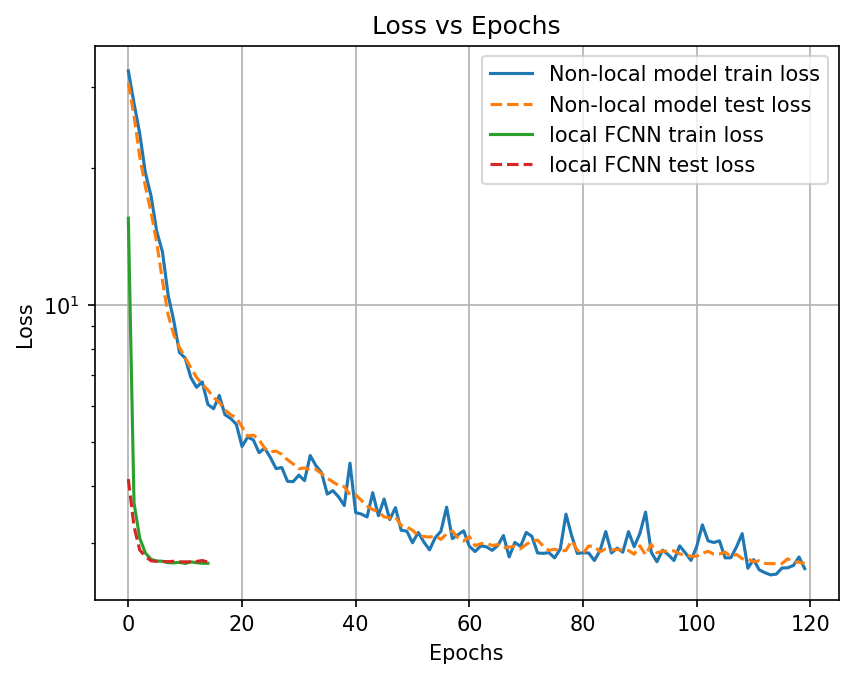

In [125]:
plt.figure(dpi=150)

plt.plot(train_loss_nonlocal, label="Non-local model train loss")
plt.plot(test_loss_nonlocal, linestyle="--", label="Non-local model test loss")

plt.plot(train_loss_fcnn, label="local FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="local FCNN test loss")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.grid()
plt.show();

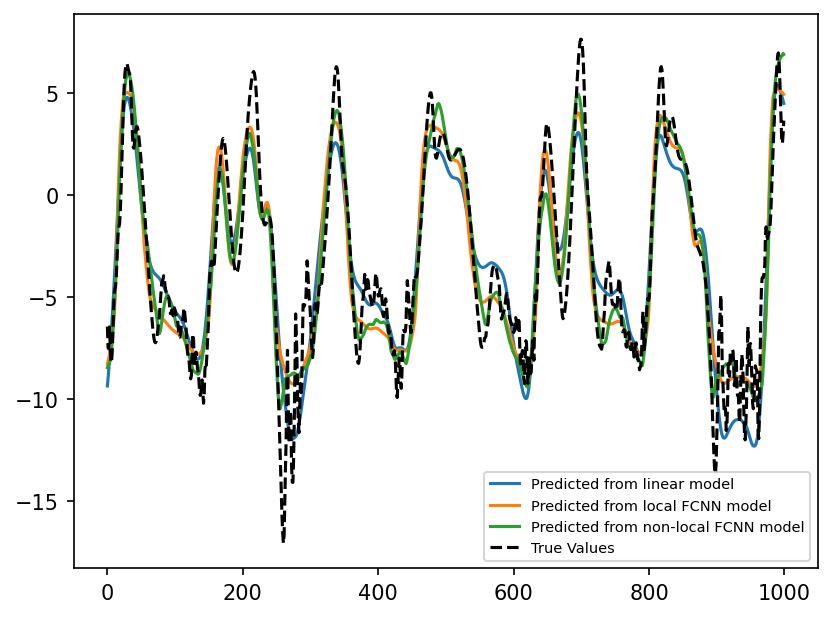

In [126]:
k_loc = 1
predictions_linear = linear_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, k_loc], -1)), 1)
)
predictions_fcnn = fcnn_network(
    torch.unsqueeze(torch.from_numpy(np.reshape(X_true_test[:, k_loc], -1)), 1)
)

predictions_nonlocal_fcnn = nonlocal_fcnn_network(torch.from_numpy(X_true_test))


plt.figure(dpi=150)
plt.plot(
    predictions_linear.detach().numpy()[0:1000], label="Predicted from linear model"
)
plt.plot(
    predictions_fcnn.detach().numpy()[0:1000], label="Predicted from local FCNN model"
)
plt.plot(
    predictions_nonlocal_fcnn.detach().numpy()[0:1000, k_loc],
    label="Predicted from non-local FCNN model",
)
plt.plot(subgrid_tend_test[:1000, 1], label="True Values", color="k", linestyle="--")
plt.legend(fontsize=7);

In [133]:
# Save network
import os
os.makedirs("./networks", exist_ok=True)

save_path = "./networks/non_local_FCNN.pth"
torch.save(nonlocal_fcnn_network.state_dict(), save_path)

save_path = "./networks/local_FCNN.pth"
torch.save(fcnn_network.state_dict(), save_path)

save_path = "./networks/linear.pth"
torch.save(linear_network.state_dict(), save_path)

## NNs for L96 Parameterizations: Online Testing

In [134]:
%matplotlib inline
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from lorenz96_model import L96, RK4, L96_eq1_xdot

In [135]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

### Load pre-trained models

In [136]:
linear_weights = torch.load("./networks/linear.pth")
local_FCNN_weights = torch.load("./networks/local_FCNN.pth")
nonlocal_FCNN_weights = torch.load("./networks/non_local_FCNN.pth")

In [137]:
# Initialize network instances and assign pre-trained weights.
linear_network = LinearRegression()
linear_network.load_state_dict(linear_weights)

local_fcnn_network = FCNN()
local_fcnn_network.load_state_dict(local_FCNN_weights)

nonlocal_fcnn_network = NonLocal_FCNN()
nonlocal_fcnn_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

### Add parameterization to GCM

In [138]:
T_test = 10
forcing = 18
dt = 0.01

k = 8
j = 32

W = L96(k, j, F=forcing)

# Full L96 model (two time scale model)
X_full, _, _ = W.run(dt, T_test)
X_full = X_full.astype(np.float32)

init_conditions = X_full[0, :]

#### GCM without NN parameterization

In [144]:
class GCM_without_parameterization:
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [142]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

#### GCM with NN parameterization

In [145]:
class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy())

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [146]:
# Evaluate with linear network
gcm_linear_net = GCM_network(forcing, linear_network)
Xnn_linear, t = gcm_linear_net(init_conditions, dt, int(T_test / dt), linear_network)

# Evaluate with local FCNN
gcm_local_net = GCM_network(forcing, local_fcnn_network)
Xnn_local, t = gcm_local_net(init_conditions, dt, int(T_test / dt), local_fcnn_network)

# Evaluate with nonlocal FCNN
gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
Xnn_nonlocal, t = gcm_nonlocal_net(
    init_conditions, dt, int(T_test / dt), nonlocal_fcnn_network
)

### Comparing Results

Text(0, 0.5, '$X_{4}$')

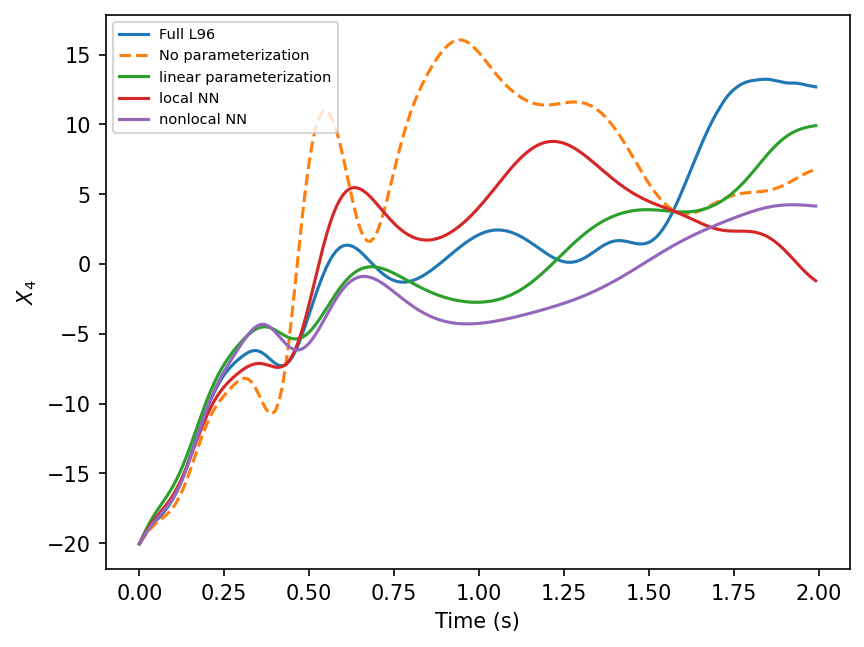

In [150]:
time_i = 200
plt.figure(dpi=150)
plt.plot(t[:time_i], X_full[:time_i, 4], label="Full L96")
plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="No parameterization")

plt.plot(t[:time_i], Xnn_linear[:time_i, 4], label="linear parameterization")

plt.plot(t[:time_i], Xnn_local[:time_i, 4], label="local NN")
plt.plot(t[:time_i], Xnn_nonlocal[:time_i, 4], label="nonlocal NN")
plt.legend(loc="upper left", fontsize=7);
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("$X_{4}$", fontsize=10)

### Checking over many different initial conditions

In [151]:
err_linear, err_local, err_nonlocal = [], [], []
T_test = 1

for i in range(90):
    init_conditions_i = X_full[i * 10, :]

    # Evaluate with linear network
    gcm_linear_net = GCM_network(forcing, linear_network)
    Xnn_linear, t = gcm_linear_net(
        init_conditions_i, dt, int(T_test / dt), linear_network
    )

    # Evaluate with local FCNN
    gcm_local_net = GCM_network(forcing, local_fcnn_network)
    Xnn_local, t = gcm_local_net(
        init_conditions_i, dt, int(T_test / dt), local_fcnn_network
    )

    # Evaluate with nonlocal FCNN
    gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
    Xnn_nonlocal, t = gcm_nonlocal_net(
        init_conditions_i, dt, int(T_test / dt), nonlocal_fcnn_network
    )

    # GCM parameterized by the global 3-layer network
    # gcm_net_3layers = GCM_network(forcing, nn_3l)
    # Xnn_3layer_i, t = gcm_net_3layers(init_conditions_i, dt, int(T_test / dt), nn_3l)

    # GCM parameterized by the linear network
    # gcm_net_1layers = GCM_network(forcing, linear_network)
    # Xnn_1layer_i, t = gcm_net_1layers(init_conditions_i, dt, int(T_test / dt), linear_network)

    err_linear.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_linear))
    )

    err_local.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_local))
    )

    err_nonlocal.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal))
    )


print(f"Sum of errors for linear: {sum(err_linear):.2f}")
print(f"Sum of errors for local neural network: {sum(err_local):.2f}")
print(f"Sum of errors for non-local neural network: {sum(err_nonlocal):.2f}")

Sum of errors for linear: 47512.50
Sum of errors for local neural network: 32101.50
Sum of errors for non-local neural network: 36945.04


## NNs for L96 Parameterizations: Online Training

In [152]:
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

from lorenz96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [153]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [154]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # You can try this if you have a GPU. However, speed up on GPU is only guaranteed after overhead cost of moving data between CPU and GPU is accounted for.
device = torch.device("cpu")

### Generate ground truth dataset

In [155]:
# Setup the two time-scale model
time_steps = 32000
forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=forcing)

In [156]:
# Run the two time-scale model

# The effect of Y on X is `xy_true`
X_true, _, _, _ = W.run(dt, T, store=True, return_coupling=True)

# Change the data type to `float32` in order to avoid doing type conversions later on
X_true = X_true.astype(np.float32)

# Notice that we only output the model trajectory here, as we don't need the coupling terms for training here.

In [158]:
# number of time steps that the training process will use for every sample
Tstep_train = 128

# We split the simulation into ensembles members without any overlap,
# and each of these will be used as a separate sample.
N_ens = int(time_steps / Tstep_train)
X_true_ens = np.reshape(X_true[0 : N_ens * Tstep_train, :], (N_ens, Tstep_train, K))
X_true_ens.shape

(250, 128, 8)

In [159]:
# Split the data into training and test

# Set the number of time series that will be part of test ensemble.
test_ens = 32

# Training Data
X_true_train = X_true_ens[0:-test_ens, :, :]

# Test Data
X_true_test = X_true_ens[-test_ens:, :, :]

In [160]:
X_true_train.shape, X_true_test.shape

((218, 128, 8), (32, 128, 8))

In [161]:
# Number of sample in each batch
BATCH_SIZE = 32

In [162]:
# Training Dataset
# ----------------
nlocal_data_train = Data.TensorDataset(
    torch.from_numpy(X_true_train[:, 0, :]),  # expected input is an initial condition
    torch.from_numpy(X_true_train),  # expected output as a time series
)

nlocal_loader_train = Data.DataLoader(
    dataset=nlocal_data_train, batch_size=BATCH_SIZE, shuffle=False
)

# Test Dataset
# ------------
nlocal_data_test = Data.TensorDataset(
    torch.from_numpy(X_true_test[:, 0, :]), torch.from_numpy(X_true_test)
)
nlocal_loader_test = Data.DataLoader(
    dataset=nlocal_data_test, batch_size=BATCH_SIZE, shuffle=False
)

### Create a differentiable 1 time-scale L96 model

In [163]:
def L96_eq1_xdot_torch(X, F=20):
    """
    Compared to older function works on batches,
    i.e. dimension is Nbatch x K (single time step for many batches is input)
    """
    return (
        torch.roll(X, shifts=1, dims=-1)
        * (torch.roll(X, shifts=-1, dims=-1) - torch.roll(X, shifts=2, dims=-1))
        - X
        + F
    )

In [165]:
def RK4(fn, dt, X, *kw):
    """
    Calculate the new state X(n+1) for d/dt X = fn(X,t,...) using the fourth order Runge-Kutta method.
    Args:
        fn     : The function returning the time rate of change of model variables X
        dt     : The time step
        X      : Values of X variables at the current time, t
        kw     : All other arguments that should be passed to fn, i.e. fn(X, t, *kw)
    Returns:
        X at t+dt
    """

    Xdot1 = fn(X, *kw)
    Xdot2 = fn(X + 0.5 * dt * Xdot1, *kw)
    Xdot3 = fn(X + 0.5 * dt * Xdot2, *kw)
    Xdot4 = fn(X + dt * Xdot3, *kw)
    return X + (dt / 6.0) * ((Xdot1 + Xdot4) + 2.0 * (Xdot2 + Xdot3))

### Define a neural network for the parameterization

In [166]:
class FCNN_nonlocal(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [167]:
fcnn_online_network = FCNN_nonlocal().to(device)

### Loss function and optimizer for online training

In [168]:
def compute_loss(NN, x_in, y_true):
    """
    NN: the neural network that parameterizes the missing terms
    x_in: initial conditions, which are the input. Shape (batch size X K)
    y_true: full solution from the two time scale model. Shape (batch size X Nt X K)
    """
    full_xdot = lambda x: NN(x) + L96_eq1_xdot_torch(
        x, F=forcing
    )  # make a function that returns tendency with NN as param.

    y_pred = 0 * y_true  # Use this to store the model prediction we make

    y_pred[:, 0, :] = x_in  # intiailize IC (which is the only input to model).

    for j in range(y_true.shape[1] - 1):  # loop over time steps
        y_pred[:, j + 1, :] = RK4(
            full_xdot, dt, y_pred[:, j, :].clone()
        )  # time step forward.

    return ((y_pred - y_true) ** 2).mean()

In [169]:
# setup optimizer.

optimizer_fcnn = optim.Adam(fcnn_online_network.parameters(), lr=0.01)

### Training

In [170]:
def train_model(network, criterion, loader, optimizer):
    """Train the network for one epoch"""
    network.train()

    train_loss = 0

    for batch_x, batch_y in loader:
        # Compute the loss (now the predictions are done directly in the loss function).
        loss = criterion(network, batch_x.to(device), batch_y.to(device))
        train_loss += loss.item()

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute the gradients and update the weights
        loss.backward()
        optimizer.step()

    return train_loss / len(loader)


def test_model(network, criterion, loader):
    """Test the network"""
    network.eval()  # Evaluation mode (important when having dropout layers)

    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            # Compute the loss
            loss = criterion(network, batch_x.to(device), batch_y.to(device))
            test_loss += loss.item()

        # Get an average loss for the entire dataset
        test_loss /= len(loader)

    return test_loss


def fit_model(network, criterion, optimizer, train_loader, test_loader, n_epochs):
    """Train and validate the network"""
    train_losses, test_losses = [], []
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train_loss = train_model(network, criterion, train_loader, optimizer)
        test_loss = test_model(network, criterion, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    end_time = time.time()
    print(f"Training completed in {int(end_time - start_time)} seconds.")

    return train_losses, test_losses

In [171]:
# Epochs refer to the number of times we iterate over the entire training data during training.
n_epochs = 100

In [173]:
# Train the model.
train_loss_online, test_loss_online = fit_model(
    fcnn_online_network,
    compute_loss,
    optimizer_fcnn,
    nlocal_loader_train,
    nlocal_loader_test,
    n_epochs,
)

Training completed in 40 seconds.


Text(0.5, 0, 'Epochs')

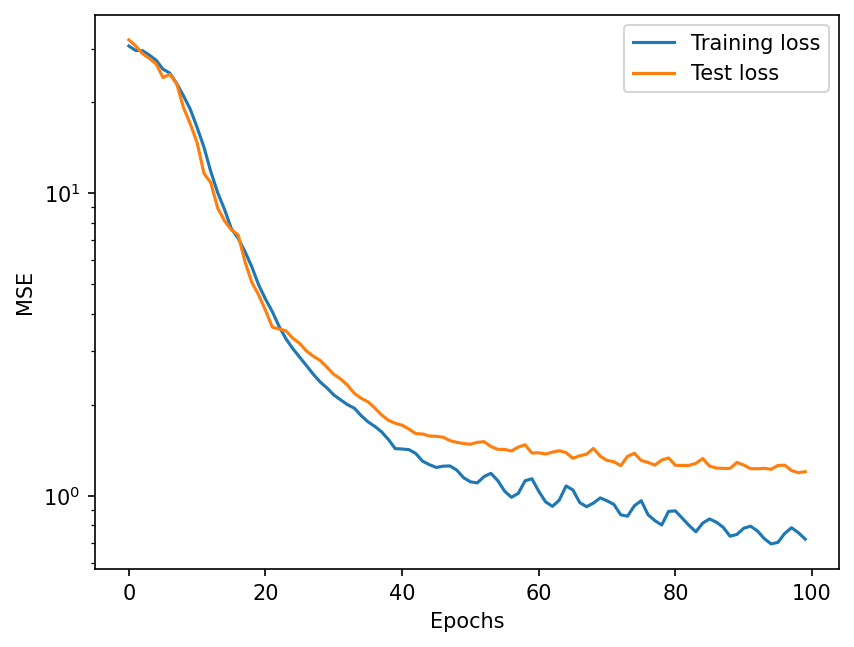

In [174]:
plt.figure(dpi=150)
plt.plot(np.array(train_loss_online), label="Training loss")
plt.plot(np.array(test_loss_online), label="Test loss")
plt.yscale("log")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epochs")

### Online testing

In [175]:
# Load in the previously trained non-local offline network.
nonlocal_FCNN_weights = torch.load("./networks/non_local_FCNN.pth")

fcnn_offline_network = FCNN_nonlocal()
fcnn_offline_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

In [176]:
# The different GCM classes
# ---------------------------


class GCM_without_parameterization:
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time


class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy())

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [177]:
start = 2100
init_conditions = X_true[start, :]
T_test = 10
forcing = 18
dt = 0.01

In [178]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

In [179]:
# Evaluate with nonlocal offline FCNN
gcm_nonlocal_offline_net = GCM_network(forcing, fcnn_offline_network)
Xnn_nonlocal_offline, t = gcm_nonlocal_offline_net(
    init_conditions, dt, int(T_test / dt), fcnn_offline_network
)

In [180]:
# Evaluate with nonlocal offline FCNN
gcm_nonlocal_online_net = GCM_network(forcing, fcnn_online_network)
Xnn_nonlocal_online, t = gcm_nonlocal_online_net(
    init_conditions, dt, int(T_test / dt), fcnn_online_network
)

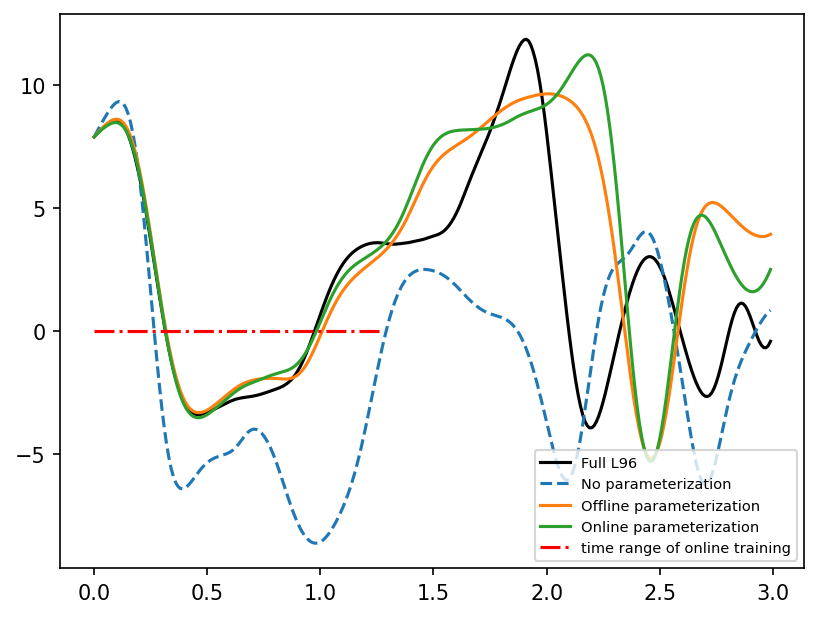

In [181]:
time_i = 300

plt.figure(dpi=150)
plt.plot(t[:time_i], X_true[start : start + time_i, 4], label="Full L96", color="k")

plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="No parameterization")

plt.plot(t[:time_i], Xnn_nonlocal_offline[:time_i, 4], label="Offline parameterization")

plt.plot(t[:time_i], Xnn_nonlocal_online[:time_i, 4], label="Online parameterization")

plt.hlines(
    0,
    t[0],
    t[Tstep_train],
    label="time range of online training",
    linestyle="-.",
    color="r",
)

plt.legend(loc="lower right", fontsize=7);

In [182]:
err_noparam, err_offline, err_online = [], [], []
T_test = 1

for i in range(100):
    init_conditions_i = X_true[i * 10, :]

    # Evaluate with no parameterization
    gcm_no_param = GCM_without_parameterization(forcing)
    X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

    # Evaluate with local FCNN
    gcm_nonlocal_offline_net = GCM_network(forcing, fcnn_offline_network)
    Xnn_nonlocal_offline, t = gcm_nonlocal_offline_net(
        init_conditions, dt, int(T_test / dt), fcnn_offline_network
    )

    # Evaluate with nonlocal FCNN
    gcm_nonlocal_online_net = GCM_network(forcing, fcnn_online_network)
    Xnn_nonlocal_online, t = gcm_nonlocal_online_net(
        init_conditions, dt, int(T_test / dt), fcnn_online_network
    )

    err_noparam.append(
        np.sum(np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - X_no_param))
    )

    err_offline.append(
        np.sum(
            np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal_offline)
        )
    )

    err_online.append(
        np.sum(np.abs(X_true[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal_online))
    )


print(f"Sum of errors for no parameterization: {sum(err_noparam):.2f}")
print(f"Sum of errors for offline parameterization: {sum(err_offline):.2f}")
print(f"Sum of errors for online parameterization: {sum(err_online):.2f}")

Sum of errors for no parameterization: 525500.26
Sum of errors for offline parameterization: 421507.32
Sum of errors for online parameterization: 419438.36
